# **Notebook Prerequisites**

In [ ]:
!pip install -U fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fastai.vision.all import *


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = 'gdrive/My Drive/Colab Notebooks/'
base_dir = root_dir + 'ball_class'
path=Path(base_dir)

Mounted at /content/gdrive


In [ ]:

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# **Data Preprocessing and Augmentation**



*   Random Splitting of the dataset (20% for Validation)
*   Resizing the images to size 200x200.
*   Applying default augmentation to our dataset



In [ ]:
fields = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=Resize((200,200)),
   batch_tfms=aug_transforms()
  )

In [ ]:
Path = '/content/gdrive/MyDrive/Stroke_classification_binary'

dls = fields.dataloaders(Path)

In [ ]:
dls.vocab

['Normal', 'Stroke']

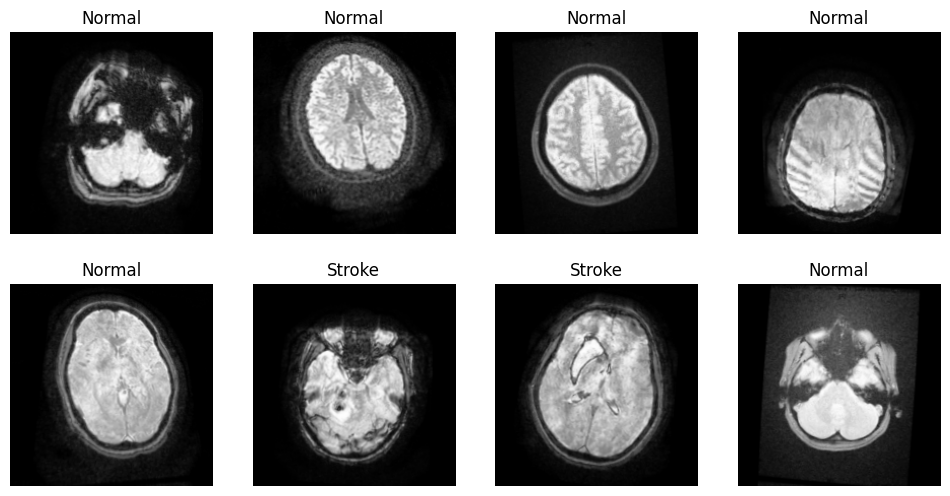

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

# **Training**

We will be training and comparing 4 different model architectures


1.   ResNet
2.   DenseNet
3.   EfficientNet
4.   VGG16



## **ResNet**

Residual Networks were introduced in the year 2015 to overcome the problem of Vanishing Gradients. **Residual Blocks** are used in this network to apply the technique of *skip connections*. The advantage of adding this type of skip connection is that if any layer hurt the performance of architecture then it will be skipped by regularization.


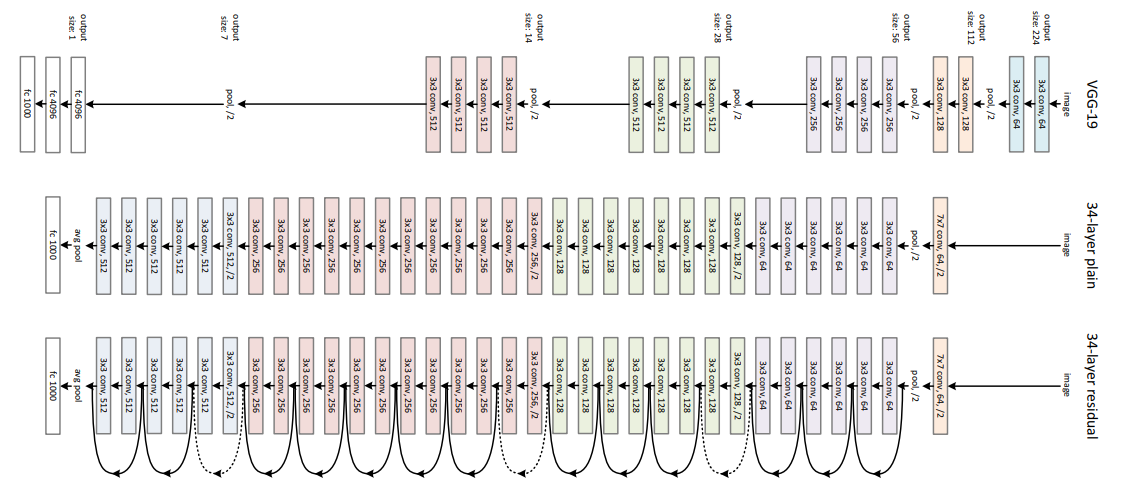


In [ ]:
learn_resent = cnn_learner(dls, resnet50, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pt

In [ ]:
learn_resent.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.025669,1.153279,0.520325,00:40
1,0.788905,1.298453,0.398374,00:08
2,0.652939,1.534765,0.414634,00:07
3,0.558985,2.294039,0.439024,00:08
4,0.479057,2.709702,0.471545,00:06


**Finetuning the baseline model**

Next, we can unfreeze all the trainable parameters from the model and continue its training.

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

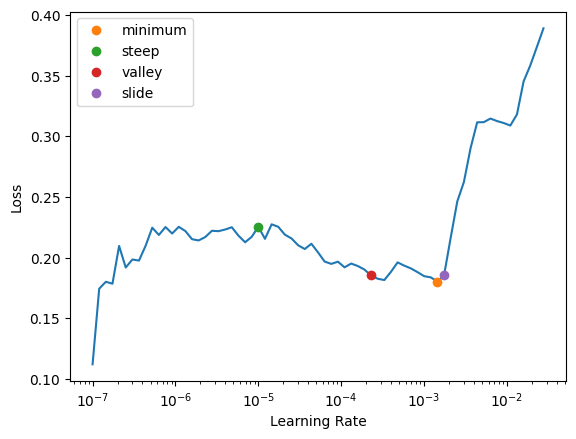

In [ ]:
learn_resent.unfreeze()
lrs = learn_resent.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lrs

SuggestedLRs(minimum=0.00014454397605732084, steep=9.999999747378752e-06, valley=0.0002290867705596611, slide=0.001737800776027143)

In [ ]:
learn_resent.fit_one_cycle(10,slice(lrs.minimum,lrs.slide))

epoch,train_loss,valid_loss,error_rate,time
0,0.273643,6.131163,0.577236,00:08
1,0.318058,1.106121,0.138211,00:08
2,0.359852,14.423270,0.243902,00:07
3,0.296736,0.834592,0.089431,00:08
4,0.243426,0.088930,0.032520,00:07
5,0.198205,0.245691,0.040650,00:08
6,0.177014,0.206386,0.081301,00:08
7,0.154112,0.070222,0.024390,00:07
8,0.131126,0.064476,0.024390,00:09
9,0.117133,0.060192,0.024390,00:07


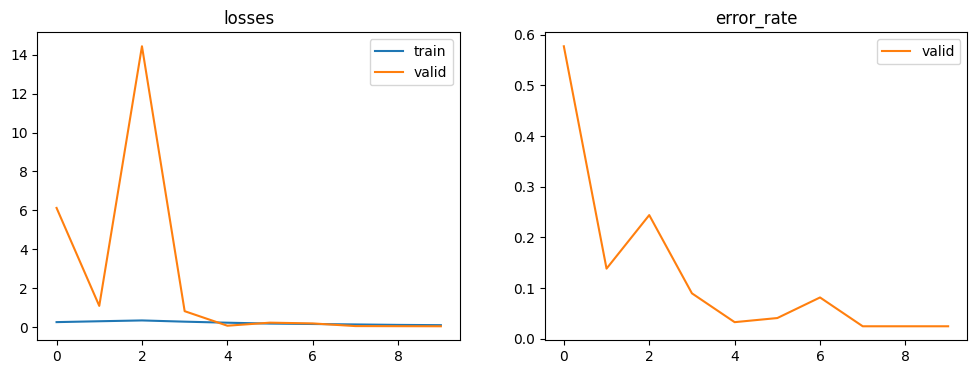

In [ ]:
learn_resent.recorder.plot_metrics()



## **DenseNet**

So dense net is densely connected-convolutional networks. It is very similar to a ResNet with some-fundamental differences. ResNet is using an additive method that means they take a previous output as an input for a future layer, & in DenseNet takes all previous output as an input for a future layer as shown in the above image.

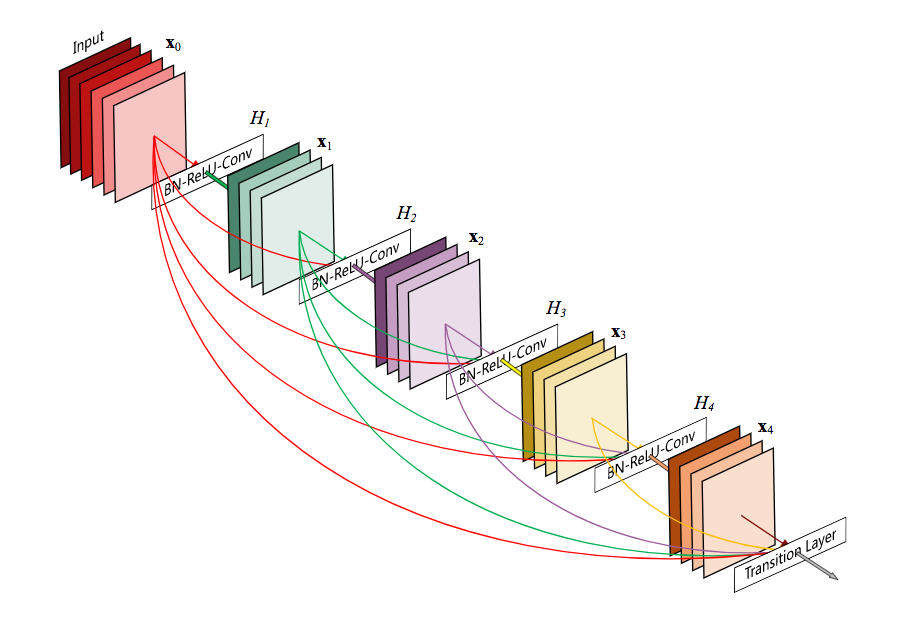


In [ ]:
learn_densenet = cnn_learner(dls, densenet201, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 66.4MB/s]


In [ ]:
learn_densenet.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.017791,0.552446,0.284553,00:08
1,0.781901,0.342151,0.154472,00:09
2,0.584894,0.311090,0.113821,00:09
3,0.456576,0.291865,0.138211,00:08
4,0.378875,0.264690,0.130081,00:09


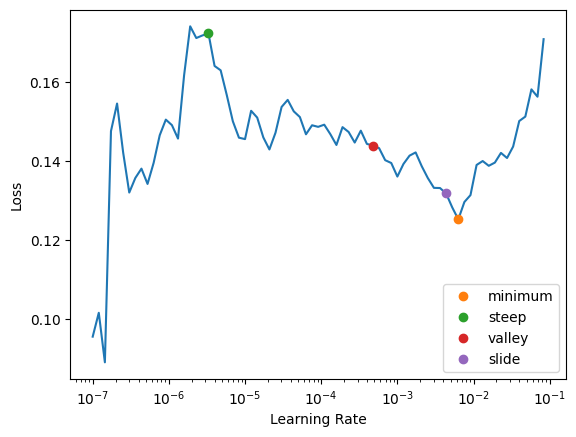

In [ ]:
lrs_densenet = learn_densenet.lr_find(suggest_funcs=(minimum, steep, valley, slide))

**Finetuning the baseline model**

Next, we can unfreeze all the trainable parameters from the model and continue its training.

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

epoch,train_loss,valid_loss,error_rate,time
0,0.140458,0.940751,0.308943,00:10
1,0.131961,0.801287,0.227642,00:09
2,0.150339,0.675814,0.130081,00:10
3,0.222444,1.369340,0.113821,00:10
4,0.191698,0.087773,0.040650,00:10
5,0.159272,0.127228,0.040650,00:09
6,0.136383,0.052606,0.016260,00:10
7,0.110599,0.046687,0.016260,00:10
8,0.092202,0.051896,0.016260,00:10
9,0.079104,0.054696,0.016260,00:09


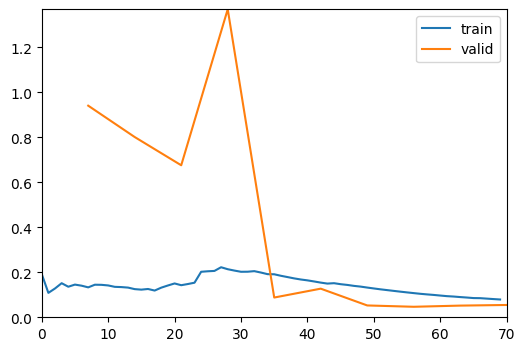

In [ ]:
learn_densenet.unfreeze()
learn_densenet.fit_one_cycle(10,slice(lrs.minimum,lrs.slide),cbs=[ShowGraphCallback()])

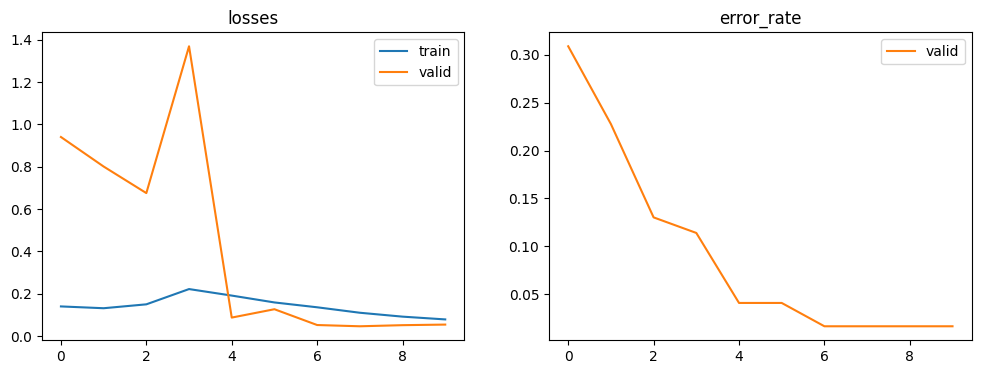

In [ ]:
learn_densenet.recorder.plot_metrics()

## **EfficientNet**

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient

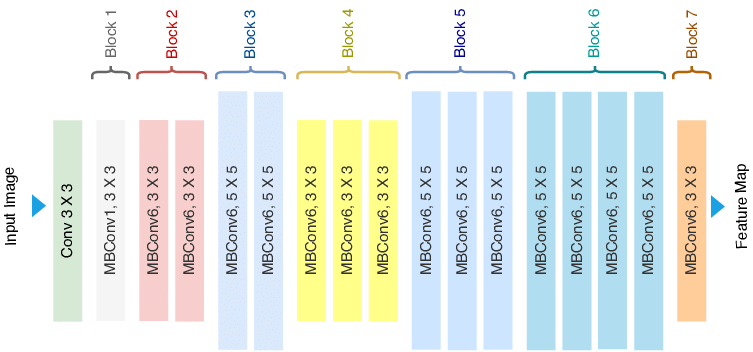

In [ ]:
learn_efficientnet = cnn_learner(dls, efficientnet_b4, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 132MB/s]


In [ ]:
learn_efficientnet.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.145213,1.264787,0.317073,00:07
1,1.001590,0.682829,0.292683,00:09
2,0.923011,0.470362,0.260163,00:09
3,0.874640,0.875470,0.398374,00:07
4,0.841826,0.770294,0.349593,00:09


**Finetuning the baseline model**

Next, we can unfreeze all the trainable parameters from the model and continue its training.

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

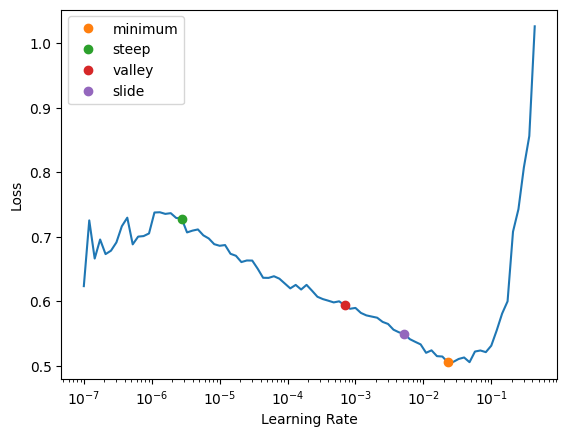

In [ ]:
learn_efficientnet.unfreeze()
lrs = learn_efficientnet.lr_find(suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,error_rate,time
0,0.678642,0.709439,0.284553,00:09
1,0.639863,3.657591,0.528455,00:09
2,0.604552,2.294670,0.333333,00:09
3,0.507808,0.972967,0.195122,00:09
4,0.424808,0.402035,0.138211,00:09
5,0.373041,0.213735,0.040650,00:09
6,0.312695,0.226757,0.065041,00:10
7,0.265404,0.163281,0.056911,00:09
8,0.223934,0.138979,0.032520,00:08
9,0.191143,0.133787,0.024390,00:10


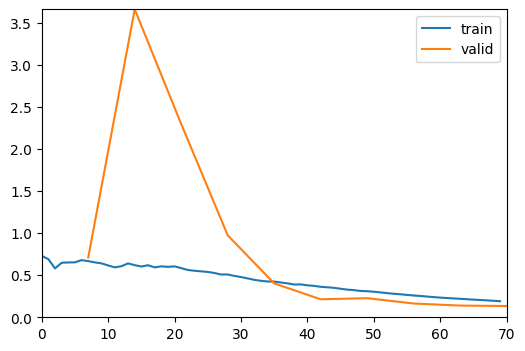

In [ ]:
learn_efficientnet.fit_one_cycle(10,slice(lrs.minimum,lrs.slide),cbs=[ShowGraphCallback()])

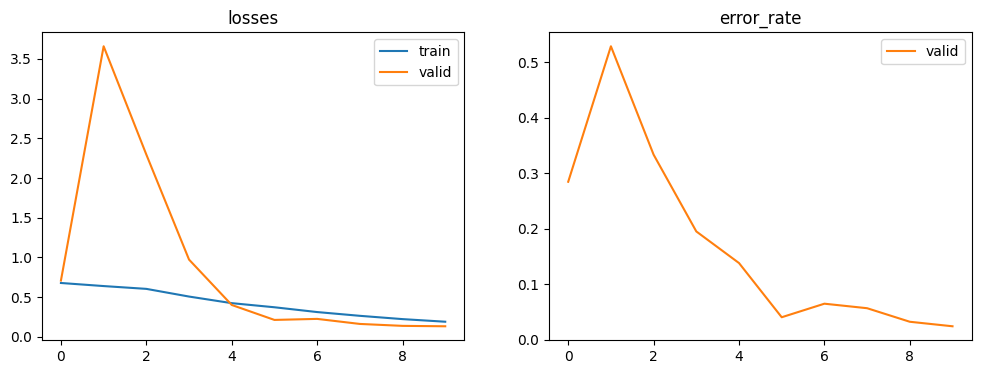

In [ ]:
learn_efficientnet.recorder.plot_metrics()

## **VGG16**

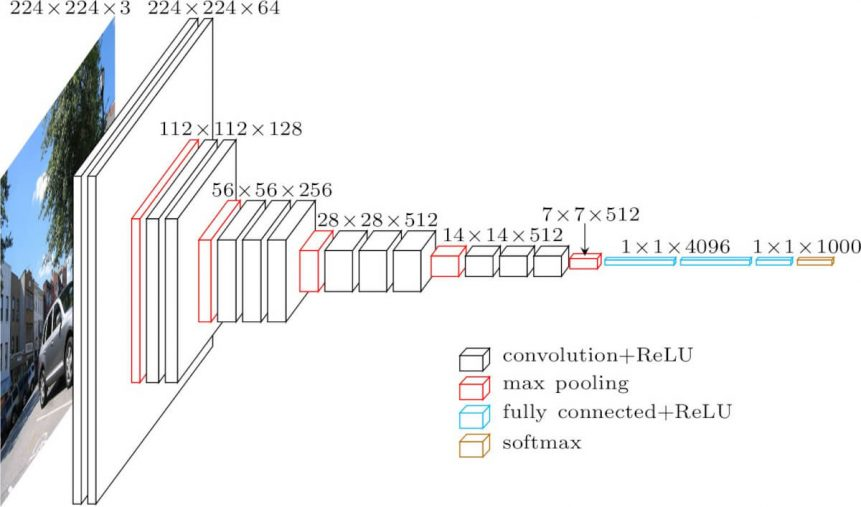

Layer architecture of the model -

- **13** Convolutional Layers
- **5** Pooling Layers
- **3** Dense Layers

In [ ]:
learn_vgg16 = cnn_learner(dls, vgg16,  metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 61.6MB/s]


In [ ]:
learn_vgg16.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.192653,1.279742,0.552846,00:08
1,0.903047,0.616030,0.276423,00:07
2,0.714329,0.453459,0.195122,00:07
3,0.620443,0.372791,0.130081,00:07
4,0.530823,0.345383,0.121951,00:06


**Finetuning the baseline model**

Next, we can unfreeze all the trainable parameters from the model and continue its training.

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

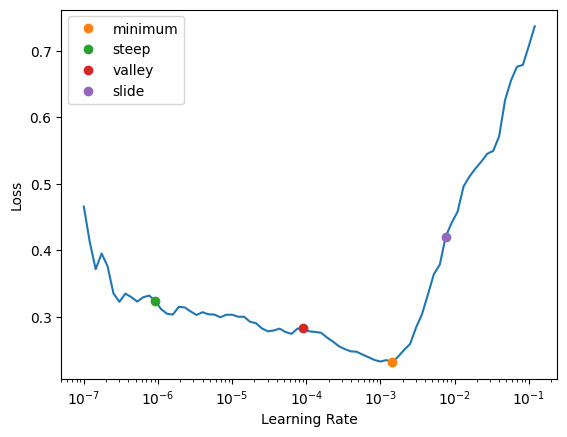

In [ ]:
learn_vgg16.unfreeze()
lr_vgg16 = learn_vgg16.lr_find(suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,error_rate,time
0,0.354615,0.182905,0.081301,00:09
1,0.278209,0.185965,0.056911,00:09
2,0.294132,1.799336,0.260163,00:08
3,0.262853,0.420043,0.089431,00:09
4,0.254358,0.494339,0.105691,00:09
5,0.236165,0.618261,0.138211,00:08
6,0.198606,0.158296,0.065041,00:10
7,0.169079,0.078626,0.032520,00:09
8,0.143020,0.063815,0.016260,00:08
9,0.122052,0.053260,0.032520,00:09


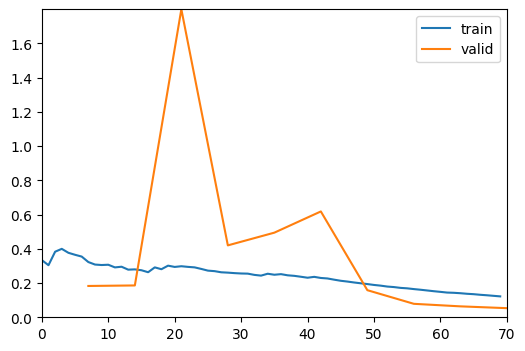

In [ ]:
learn_vgg16.fit_one_cycle(10,slice(lr_vgg16.minimum,lr_vgg16.slide),cbs=[ShowGraphCallback()])

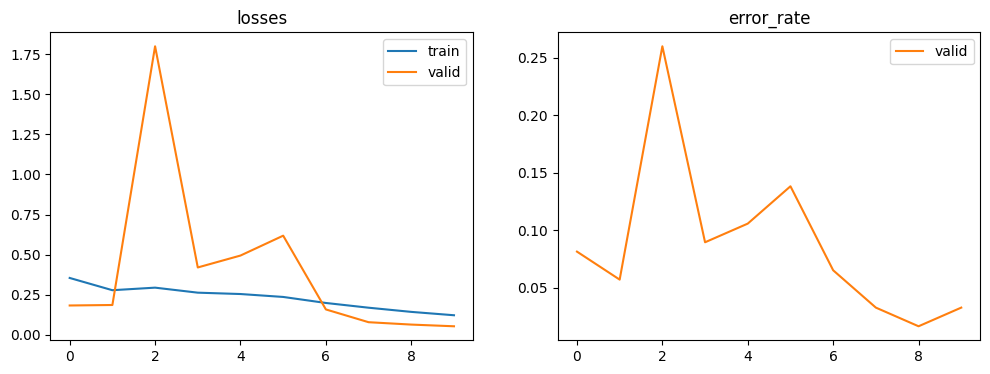

In [ ]:
learn_vgg16.recorder.plot_metrics()

# **Model Evaluation and Accuracy**

## Classification Report

In [ ]:
interp_res = ClassificationInterpretation.from_learner(learn_resent)
interp_den = ClassificationInterpretation.from_learner(learn_densenet)
interp_vgg16 = ClassificationInterpretation.from_learner(learn_vgg16)
interp_efficientnet = ClassificationInterpretation.from_learner(learn_efficientnet)

In [ ]:
print("ResNet Classification report\n")
interp_res.print_classification_report()
print("-------------------------------------------------------")

print("DenseNet Classification report\n")
interp_den.print_classification_report()
print("-------------------------------------------------------")

print("EfficientNet Classification report\n")
interp_efficientnet.print_classification_report()
print("-------------------------------------------------------")

print("VGG16 Classification report\n")
interp_vgg16.print_classification_report()
print("-------------------------------------------------------")

ResNet Classification report



              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98        83
      Stroke       0.95      0.97      0.96        40

    accuracy                           0.98       123
   macro avg       0.97      0.98      0.97       123
weighted avg       0.98      0.98      0.98       123

-------------------------------------------------------
DenseNet Classification report



              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99        83
      Stroke       1.00      0.95      0.97        40

    accuracy                           0.98       123
   macro avg       0.99      0.97      0.98       123
weighted avg       0.98      0.98      0.98       123

-------------------------------------------------------
EfficientNet Classification report



              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98        83
      Stroke       1.00      0.93      0.96        40

    accuracy                           0.98       123
   macro avg       0.98      0.96      0.97       123
weighted avg       0.98      0.98      0.98       123

-------------------------------------------------------
VGG16 Classification report



              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98        83
      Stroke       0.95      0.95      0.95        40

    accuracy                           0.97       123
   macro avg       0.96      0.96      0.96       123
weighted avg       0.97      0.97      0.97       123

-------------------------------------------------------


## Confusion Matrix

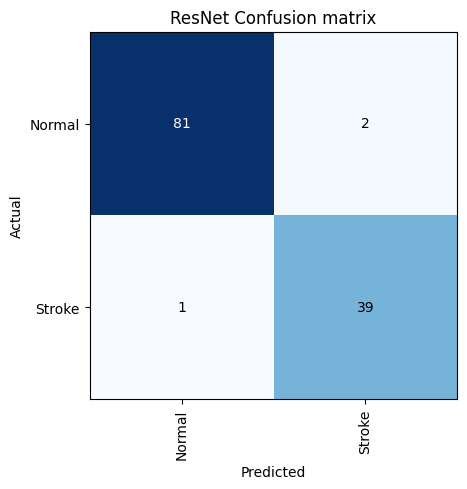

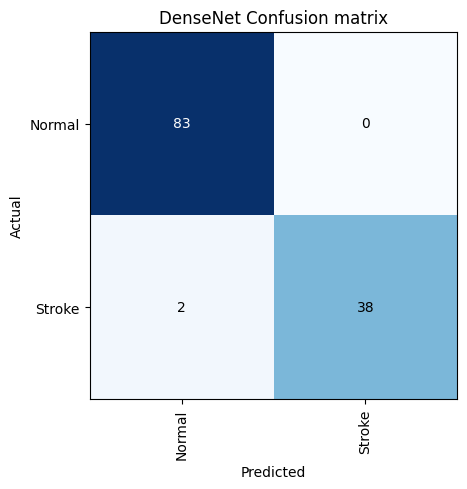

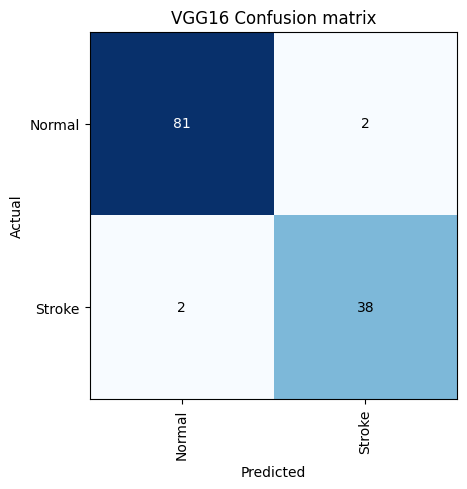

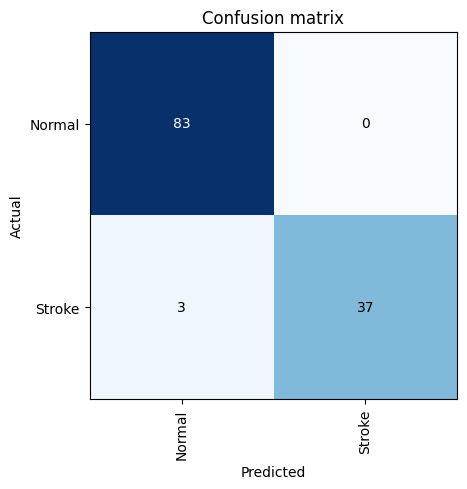

In [ ]:

interp_res.plot_confusion_matrix(title='ResNet Confusion matrix')
interp_den.plot_confusion_matrix(title='DenseNet Confusion matrix')
interp_vgg16.plot_confusion_matrix(title='VGG16 Confusion matrix')
interp_efficientnet.plot_confusion_matrix(title='Confusion matrix')


## Accuracy of each models

In [ ]:

def print_acc(learn):
  preds,y, loss = learn.get_preds(with_loss=True)
  acc = accuracy(preds, y)
  return acc

print('ResNet accuracy is {0} %.'.format(print_acc(learn_resent)))
print('DenseNet accuracy is {0} %.'.format(print_acc(learn_densenet)))
print('EfficientNet accuracy is {0} %.'.format(print_acc(learn_efficientnet)))
print('VGG16 accuracy is {0} %.'.format(print_acc(learn_vgg16)))


ResNet accuracy is TensorBase(0.9756) %.


DenseNet accuracy is TensorBase(0.9837) %.


EfficientNet accuracy is TensorBase(0.9756) %.


VGG16 accuracy is TensorBase(0.9675) %.


From the above results we find **DenseNet** Model having the highest accuracy of **99.2 %**

## AUC ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
preds,y, loss = learn_densenet.get_preds(with_loss=True)
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))


ROC area is 0.9984939759036144


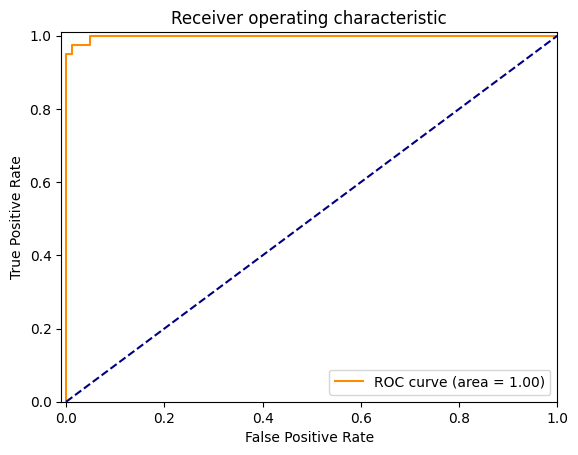

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")